In [21]:
import sys
sys.path.append("..")

import time
from enum import Enum
import torch
from utils import compute_min_max
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Import dataset loaders
from dataset_loaders.MNIST import get_MNIST
from dataset_loaders.FASHION_MNIST import get_FASHION_MNIST
from dataset_loaders.CIFAR import get_CIFAR
from dataset_loaders.TINY_IMAGENET import get_TINY_IMAGENET

# Import architectures
from architectures.CKAN_KAN import *
from architectures.CKAN_LIN import *
from architectures.CNN_KAN import *
from architectures.CNN_LIN import *

# Use this file to conduct our experiments

### First check if we can run on GPU:

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


### Select the dataset:

In [3]:
class Dataset(Enum):
    MNIST = 1
    FASH_MNIST = 2
    CIFAR = 3
    TINY_IMAGENET = 4

    def get_dataset(self, fraction, batch_size):
        if self == Dataset.MNIST:
            return get_MNIST(fraction, batch_size)
        elif self == Dataset.FASH_MNIST:
            return get_FASHION_MNIST(fraction, batch_size)
        elif self == Dataset.CIFAR:
            return get_CIFAR(fraction, batch_size)
        elif self == Dataset.TINY_IMAGENET:
            return get_TINY_IMAGENET(fraction, batch_size)
        else:
            return "Unknown option"

In [4]:
# Change enum to pick different dataset
dataset = Dataset.MNIST

# Set the required variables
fraction = 0.001
batch_size = 32

train_val_dataset, test_dataset, train_loader, test_loader = dataset.get_dataset(fraction, batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9395167.49it/s] 


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 269983.58it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2875446.39it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 596746.30it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



### Select which architecture we want to use:

In [5]:
class Architecture(Enum):
    CKAN_KAN = 1
    CKAN_LIN = 2
    CNN_KAN  = 3 
    CNN_LIN  = 4

    def get_architecture(self, in_channels, hidden_channels, out_features, min_grid, degree, device):
        if self == Architecture.CKAN_KAN:
            return CKANKANNet(in_channels, hidden_channels, out_features, 
                              grid=min_grid, degree=degree, device=device).to(device)
        elif self == Architecture.CKAN_LIN:
            return CKANLINNet(in_channels, hidden_channels, out_features, 
                              grid=min_grid, degree=degree, device=device).to(device)
        elif self == Architecture.CNN_KAN:
            return CNNKANNet(in_channels, hidden_channels, out_features, 
                              grid=min_grid, degree=degree, device=device).to(device)
        elif self == Architecture.CNN_LIN:
            return CNNLINNet(in_channels, hidden_channels, out_features, device=device).to(device)
        else:
            return "Unknown option"

In [6]:
# Change enum to pick different architecture
architecture = Architecture.CKAN_LIN

degree = 2

# Architecture parameters
in_channels = 1
hidden_channels = [2, 3]
out_features = 10

# Training parameters
learning_rate = 0.01
num_epochs = 50

# Grid parameters
min_grid = 1
max_grid, curr_grid = 13, min_grid
grid_range = compute_min_max(train_val_dataset)
step = 4
grid_update_freq = int(num_epochs / ((max_grid - min_grid) / step + 1e-5))

net = architecture.get_architecture(in_channels, hidden_channels, out_features, min_grid, degree, device)

In [7]:
# Optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Define model metrics:

We measure
- Accuracy
- Precision
- Recall
- F1-score

In [25]:
def evaluate_model(data_loader, net, device=torch.device('cuda:0')):
    """
    Evaluate a model on the given data.
    """
    net.eval()
    all_y_true = []
    all_y_pred = []

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            y_pred = torch.argmax(net(X), dim=1)
            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(y_pred.cpu().numpy())

    accuracy = accuracy_score(all_y_true, all_y_pred) * 100
    precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=1)
    recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=1)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted')

    return accuracy, precision, recall, f1

Store metrics:

In [29]:
# Losses and training times
train_losses = []
epoch_times = []

# Accuracies
train_accs = []
test_accs = []

# Precisions
train_precs = []
test_precs = []

# Recalls
train_recs = []
test_recs = []

# F1-scores
train_f1s = []
test_f1s = []

### Run the training loop:

In [31]:
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Grid extension (except for CNN_LIN architecture)
    if (architecture != Architecture.CNN_LIN):
        if (epoch + 1) % grid_update_freq == 0 and curr_grid < max_grid and epoch > 0:
            curr_grid += step
            print(f"Updating grid to {curr_grid} in epoch {epoch+1}")
            net.update_grid(curr_grid)
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Network in training mode
    net.train()

    # Training loop
    for x_batch, y_batch in train_loader:
        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = net(x_batch)

        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)

        loss.backward()
        optimizer.step()

    # Compute model performance metrics
    train_acc, train_prec, train_rec, train_f1 = evaluate_model(train_loader, net.to(device), device)
    test_acc, test_prec, test_rec, test_f1 = evaluate_model(test_loader, net.to(device), device)

    # Store values
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    train_precs.append(train_prec)
    test_precs.append(test_prec)

    train_recs.append(train_rec)
    test_recs.append(test_rec)

    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    # Print performance
    print(f'Epoch: {epoch+1}')
    print(f'Accuracy of train set: {train_acc:.2f}%, Accuracy of test set: {test_acc:.2f}%')
    print(f'Precision of train set: {train_prec:.2f}%, Precision of test set: {test_prec:.2f}%')
    print(f'Recall of train set: {train_rec:.2f}%, Recall of test set: {test_rec:.2f}%')
    print(f'F1-score of train set: {train_f1:.2f}%, F1-score of test set: {test_f1:.2f}%')
    print('')

    # Store training time of epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)

total_time = time.time() - start_time

Epoch: 1
Accuracy of train set: 100.00%, Accuracy of test set: 80.00%
Precision of train set: 1.00%, Precision of test set: 0.95%
Recall of train set: 1.00%, Recall of test set: 0.80%
F1-score of train set: 1.00%, F1-score of test set: 0.80%

Epoch: 2
Accuracy of train set: 100.00%, Accuracy of test set: 80.00%
Precision of train set: 1.00%, Precision of test set: 0.95%
Recall of train set: 1.00%, Recall of test set: 0.80%
F1-score of train set: 1.00%, F1-score of test set: 0.80%

Epoch: 3
Accuracy of train set: 100.00%, Accuracy of test set: 80.00%
Precision of train set: 1.00%, Precision of test set: 0.95%
Recall of train set: 1.00%, Recall of test set: 0.80%
F1-score of train set: 1.00%, F1-score of test set: 0.80%

Epoch: 4
Accuracy of train set: 100.00%, Accuracy of test set: 80.00%
Precision of train set: 1.00%, Precision of test set: 0.95%
Recall of train set: 1.00%, Recall of test set: 0.80%
F1-score of train set: 1.00%, F1-score of test set: 0.80%

Epoch: 5
Accuracy of train s

### Results & Visualizations:

Training time:

In [32]:
avg_epoch_time = np.mean(epoch_times)

print(f"Total training time: {total_time:.2f} seconds")
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")

Total training time: 9.77 seconds
Average time per epoch: 0.20 seconds


Inference time:

In [33]:
net.eval()
start_time = time.time()

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)

end_time = time.time()
inference_time = end_time - start_time
print(f'Total Inference Time: {inference_time} seconds for {len(test_loader.dataset)} samples')

Total Inference Time: 0.07763099670410156 seconds for 10 samples


Number of parameters:

In [34]:
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}, Trainable parameters: {trainable_params}')

Total parameters: 3082, Trainable parameters: 2704


Plots:

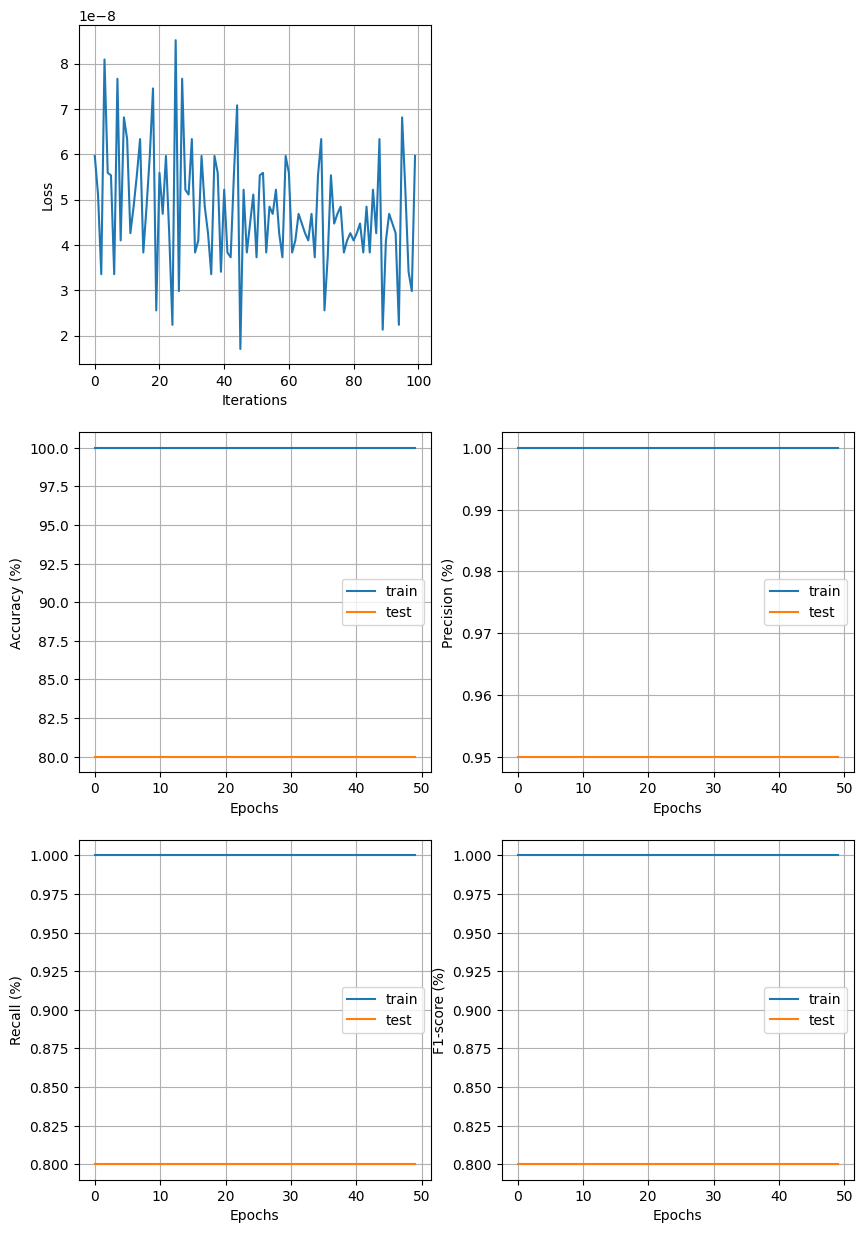

In [38]:
# Assuming 'train_losses' is a list of tensors
train_losses_detached = [loss.detach().cpu().numpy() for loss in train_losses]

plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses_detached)  # Use the detached list of numpy arrays
plt.grid()

plt.subplot(3, 2, 3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()
plt.subplot(3, 2, 4)
plt.xlabel('Epochs')
plt.ylabel('Precision (%)')
plt.plot(train_precs, label = 'train')
plt.plot(test_precs, label = 'test')
plt.legend()
plt.grid()

plt.subplot(3, 2, 5)
plt.xlabel('Epochs')
plt.ylabel('Recall (%)')
plt.plot(train_recs, label = 'train')
plt.plot(test_recs, label = 'test')
plt.legend()
plt.grid()
plt.subplot(3, 2, 6)
plt.xlabel('Epochs')
plt.ylabel('F1-score (%)')
plt.plot(train_f1s, label = 'train')
plt.plot(test_f1s, label = 'test')
plt.legend()
plt.grid()